In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision numpy opencv-python matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib
import seaborn as sns
from tqdm import tqdm_notebook
%matplotlib inline
import cv2 as cv

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import copy
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Subset

In [ ]:
print(torch.cuda.is_available())

True


# **RESNET50**

> **SPIRAL IMAGES**

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng resnet50
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Sửa normalization cho ImageNet
])

Using device: cuda

=== Training with Learning Rate: 0.001 ===
Fold 1/5
Epoch 1/20: Train Loss: 0.8410, Train Acc: 0.4561, Val Loss: 0.7293, Val Acc: 0.6667
Epoch 2/20: Train Loss: 0.8708, Train Acc: 0.6842, Val Loss: 0.7522, Val Acc: 0.7333
Epoch 3/20: Train Loss: 0.8221, Train Acc: 0.7018, Val Loss: 2.0695, Val Acc: 0.7333
Epoch 4/20: Train Loss: 0.4794, Train Acc: 0.6842, Val Loss: 4.2156, Val Acc: 0.8000
Epoch 5/20: Train Loss: 0.3940, Train Acc: 0.8596, Val Loss: 3.2327, Val Acc: 0.7333
Epoch 6/20: Train Loss: 0.3766, Train Acc: 0.8246, Val Loss: 1.2233, Val Acc: 0.8667
Epoch 7/20: Train Loss: 0.3620, Train Acc: 0.8772, Val Loss: 1.0368, Val Acc: 0.8000
Epoch 8/20: Train Loss: 0.2739, Train Acc: 0.9123, Val Loss: 0.6679, Val Acc: 0.8667
Epoch 9/20: Train Loss: 0.2367, Train Acc: 0.9474, Val Loss: 0.4062, Val Acc: 0.8667
Epoch 10/20: Train Loss: 0.2509, Train Acc: 0.9474, Val Loss: 0.5182, Val Acc: 0.8000
Epoch 11/20: Train Loss: 0.2346, Train Acc: 0.9298, Val Loss: 0.4226, Val Acc

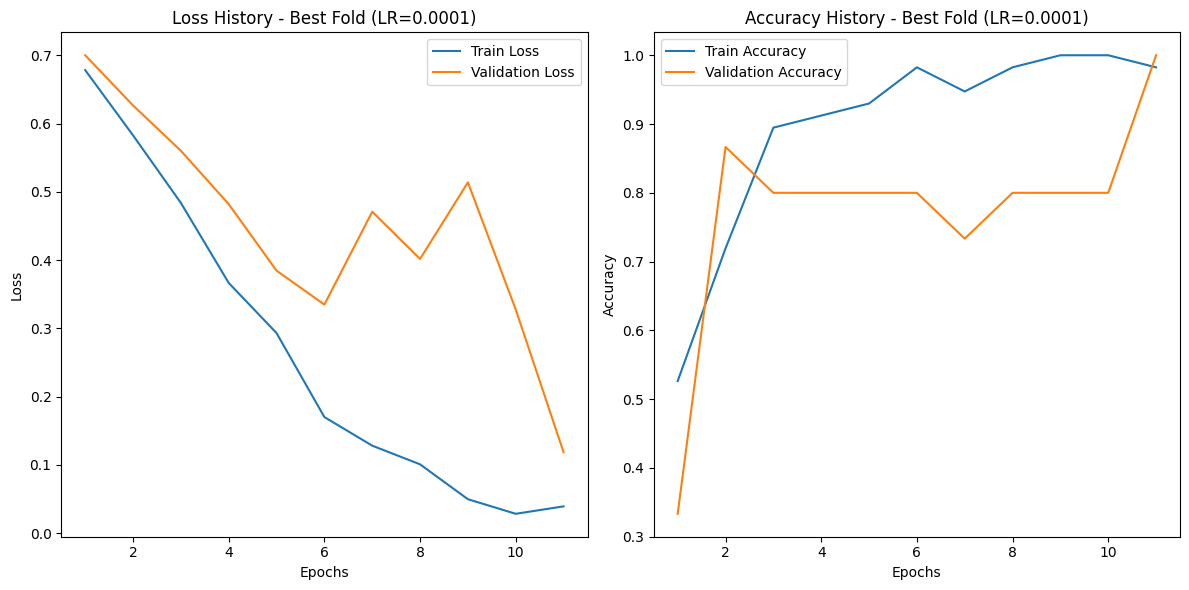

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from sklearn.model_selection import KFold
import copy
import matplotlib.pyplot as plt

# Thêm rotation và flip để mô hình học được nhiều góc độ của ảnh
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng resnet50
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Sửa normalization cho ImageNet
])

dataset_path_spiral = "/content/drive/MyDrive/Colab Notebooks/img_data/spiral"
dataset1 = datasets.ImageFolder(root=f"{dataset_path_spiral}/training", transform=transform)
num_classes = len(dataset1.classes)

test_dataset = datasets.ImageFolder(root=f"{dataset_path_spiral}/testing", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # Thêm random_state
learning_rates = [1e-3, 1e-4, 1e-5]  # tuning learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Biến để lưu best của learning rate tốt nhất
best_lr = None
best_lr_avg_acc = 0.0
best_lr_model_state = None
best_lr_train_loss_history = None
best_lr_val_loss_history = None
best_lr_train_acc_history = None
best_lr_val_acc_history = None
best_lr_fold_results = None

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    fold_results = []

    # Biến để lưu best fold của learning rate hiện tại
    best_fold_for_lr_acc = 0.0
    best_fold_for_lr_model = None
    best_fold_for_lr_train_loss = None
    best_fold_for_lr_val_loss = None
    best_fold_for_lr_train_acc = None
    best_fold_for_lr_val_acc = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset1)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler = torch.utils.data.Subset(dataset1, train_idx)
        val_subsampler = torch.utils.data.Subset(dataset1, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=32, shuffle=False)

        # Sử dụng phiên bản mới của torchvision
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Sửa cách load pretrained
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Bỏ verbose

        best_fold_acc = 0.0
        best_fold_model = None

        # Thêm biến để lưu history của best fold
        best_fold_train_loss_history = None
        best_fold_val_loss_history = None
        best_fold_train_acc_history = None
        best_fold_val_acc_history = None

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        for epoch in range(20):  # Giảm epoch để test nhanh
            model.train()
            running_loss, correct_train = 0.0, 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)
                total_train += labels.size(0)

            train_loss = running_loss / total_train
            train_acc = correct_train / total_train

            # Validation
            model.eval()
            running_val_loss, correct_val = 0.0, 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)
                    total_val += labels.size(0)

            val_loss = running_val_loss / total_val if total_val > 0 else 0
            val_acc = correct_val / total_val if total_val > 0 else 0

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/20: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = copy.deepcopy(model.state_dict())
                # Lưu history của best epoch trong fold
                best_fold_train_loss_history = train_loss_history.copy()
                best_fold_val_loss_history = val_loss_history.copy()
                best_fold_train_acc_history = train_acc_history.copy()
                best_fold_val_acc_history = val_acc_history.copy()

        fold_results.append(best_fold_acc)
        print(f"Best fold accuracy: {best_fold_acc:.4f}")

        # Cập nhật best fold cho learning rate hiện tại
        if best_fold_acc > best_fold_for_lr_acc:
            best_fold_for_lr_acc = best_fold_acc
            best_fold_for_lr_model = best_fold_model
            best_fold_for_lr_train_loss = best_fold_train_loss_history
            best_fold_for_lr_val_loss = best_fold_val_loss_history
            best_fold_for_lr_train_acc = best_fold_train_acc_history
            best_fold_for_lr_val_acc = best_fold_val_acc_history

    avg_acc = np.mean(fold_results)
    print(f"Learning Rate {lr} - Fold Accuracies: {fold_results}")
    print(f"Average Accuracy for LR={lr}: {avg_acc:.4f} ± {np.std(fold_results):.4f}")

    # Cập nhật best learning rate
    if avg_acc > best_lr_avg_acc:
        best_lr_avg_acc = avg_acc
        best_lr = lr
        best_lr_model_state = best_fold_for_lr_model
        best_lr_train_loss_history = best_fold_for_lr_train_loss
        best_lr_val_loss_history = best_fold_for_lr_val_loss
        best_lr_train_acc_history = best_fold_for_lr_train_acc
        best_lr_val_acc_history = best_fold_for_lr_val_acc
        best_lr_fold_results = fold_results.copy()

    print(f"Current best LR: {best_lr} with avg accuracy: {best_lr_avg_acc:.4f}\n")

# Lưu model
if best_lr_model_state is not None:
    torch.save(best_lr_model_state, "best_resnet50_T1_huhu.pth")
    print(f"Best model saved with learning rate: {best_lr}")
    print(f"Best fold accuracy: {max(best_lr_fold_results):.4f}")
    print(f"Average accuracy across folds: {best_lr_avg_acc:.4f}")

    # Vẽ biểu đồ history của best fold từ learning rate tốt nhất
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_lr_train_loss_history) + 1), best_lr_train_loss_history, label="Train Loss")
    plt.plot(range(1, len(best_lr_val_loss_history) + 1), best_lr_val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss History - Best Fold (LR={best_lr})")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_lr_train_acc_history) + 1), best_lr_train_acc_history, label="Train Accuracy")
    plt.plot(range(1, len(best_lr_val_acc_history) + 1), best_lr_val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy History - Best Fold (LR={best_lr})")
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet50(pretrained=True)
model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model_resnet.load_state_dict(torch.load("/content/best_resnet50_T1_huhu.pth", map_location=device))
model_resnet.to(device)
model_resnet.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader: #thay của val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset1.classes))


Classification Report:
              precision    recall  f1-score   support

     healthy       0.93      0.93      0.93        15
   parkinson       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

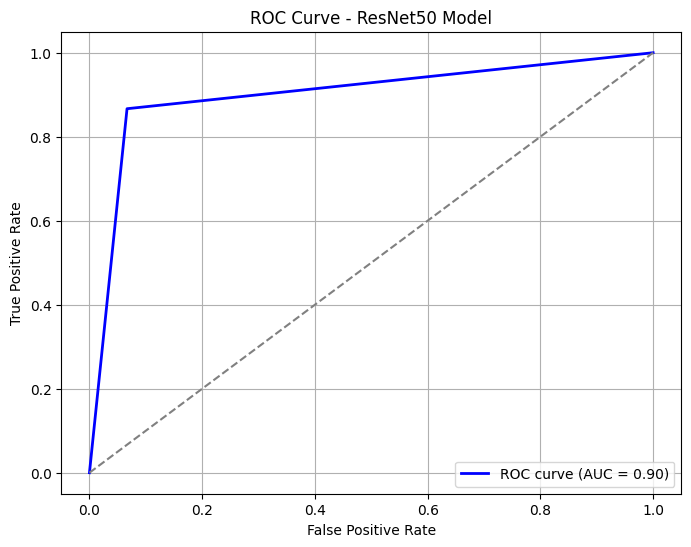

In [ ]:
model.load_state_dict(torch.load("/content/best_resnet50_T1_huhu.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader: #thay của val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_SR2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_SR2.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_SR2.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


Model loaded successfully!


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/img_data/drawings/spiral/testing/testfvck"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh V14PE03.png: Parkinson
Ảnh V08HE01.png: Healthy
Ảnh V10PE03.png: Healthy
Ảnh V55HE15.png: Healthy
Ảnh V10HE01.png: Healthy
Ảnh V08PE01.png: Healthy
Ảnh V07PE01.png: Parkinson
Ảnh V04PE01.png: Parkinson
Ảnh V05HE01.png: Healthy
Ảnh V07HE01.png: Healthy
Ảnh V01HE01.png: Healthy
Ảnh V01PE01.png: Healthy
Ảnh V06PE01.png: Parkinson
Ảnh V55HE13.png: Healthy
Ảnh V11HE01.png: Healthy
Ảnh V09PE01.png: Parkinson
Ảnh V55HE12.png: Healthy
Ảnh V11PE03.png: Healthy
Ảnh V03HE1.png: Healthy
Ảnh V06HE01.png: Healthy
Ảnh V03PE01.png: Parkinson
Ảnh V03PE04.png: Parkinson
Ảnh V04HE01.png: Healthy
Ảnh V15PE01.png: Parkinson
Ảnh V05PE01.png: Parkinson
Ảnh V03PE07.png: Parkinson
Ảnh V02HE01.png: Parkinson
Ảnh V09HE01.png: Healthy
Ảnh V02PE01.png: Parkinson
Ảnh V55HE14.png: Healthy


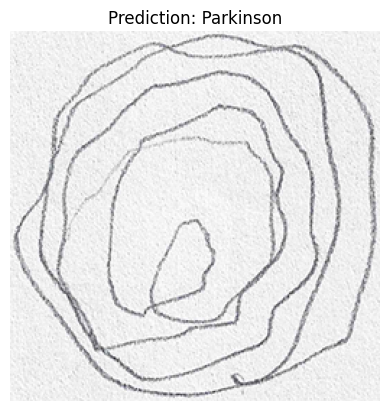

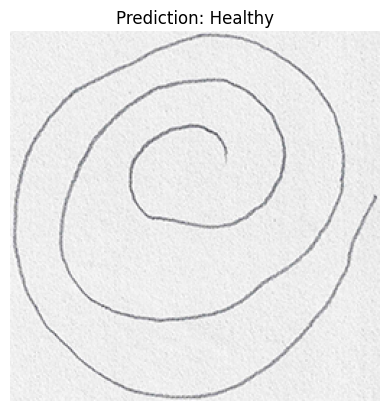

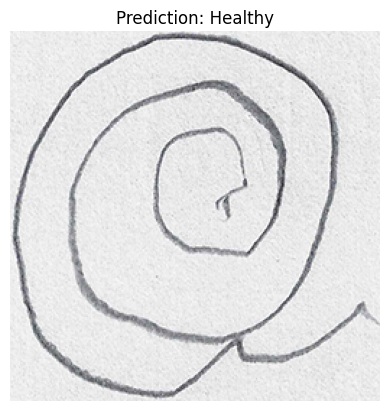

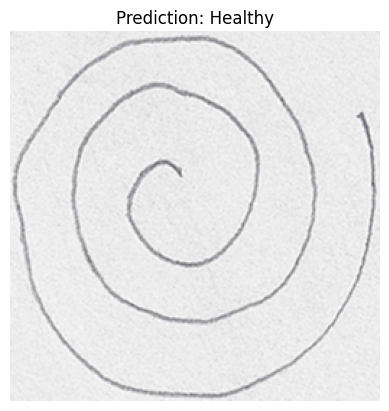

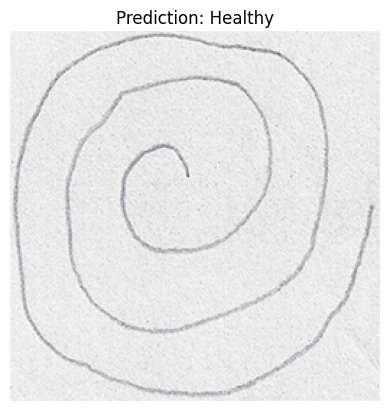

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

> **WAVE IMAGES**

Using device: cuda

=== Training with Learning Rate: 0.001 ===
Fold 1/5
Epoch 1/20: Train Loss: 0.8828, Train Acc: 0.5614, Val Loss: 1.8536, Val Acc: 0.4000
Epoch 2/20: Train Loss: 0.6721, Train Acc: 0.5789, Val Loss: 1.8752, Val Acc: 0.4000
Epoch 3/20: Train Loss: 0.4525, Train Acc: 0.7895, Val Loss: 40.4100, Val Acc: 0.4667
Epoch 4/20: Train Loss: 0.3551, Train Acc: 0.8246, Val Loss: 34.6248, Val Acc: 0.5333
Epoch 5/20: Train Loss: 0.1606, Train Acc: 0.9825, Val Loss: 9.3562, Val Acc: 0.7333
Epoch 6/20: Train Loss: 0.1876, Train Acc: 0.9123, Val Loss: 5.1346, Val Acc: 0.8000
Epoch 7/20: Train Loss: 0.0969, Train Acc: 0.9298, Val Loss: 2.7905, Val Acc: 0.8000
Epoch 8/20: Train Loss: 0.1416, Train Acc: 0.9298, Val Loss: 2.5468, Val Acc: 0.7333
Epoch 9/20: Train Loss: 0.1222, Train Acc: 0.9825, Val Loss: 2.2017, Val Acc: 0.6667
Epoch 10/20: Train Loss: 0.1011, Train Acc: 0.9474, Val Loss: 2.0259, Val Acc: 0.6667
Epoch 11/20: Train Loss: 0.1211, Train Acc: 0.9649, Val Loss: 2.3382, Val A

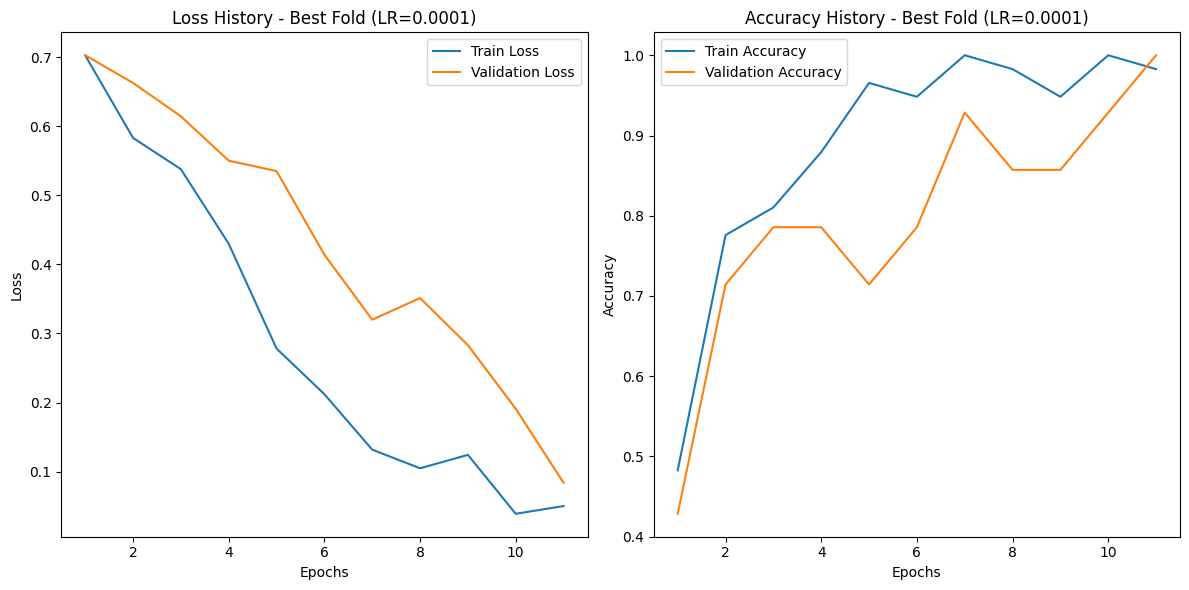

In [ ]:
# Thêm rotation và flip để mô hình học được nhiều góc độ của ảnh
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng resnet50
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Sửa normalization cho ImageNet
])

dataset_wave = "/content/drive/MyDrive/Colab Notebooks/img_data/wave"
dataset1 = datasets.ImageFolder(root=f"{dataset_wave}/training", transform=transform)
num_classes = len(dataset1.classes)

test_dataset = datasets.ImageFolder(root=f"{dataset_wave}/testing", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # Thêm random_state
learning_rates = [1e-3, 1e-4, 1e-5]  # tuning learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Biến để lưu best của learning rate tốt nhất
best_lr = None
best_lr_avg_acc = 0.0
best_lr_model_state = None
best_lr_train_loss_history = None
best_lr_val_loss_history = None
best_lr_train_acc_history = None
best_lr_val_acc_history = None
best_lr_fold_results = None

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    fold_results = []

    # Biến để lưu best fold của learning rate hiện tại
    best_fold_for_lr_acc = 0.0
    best_fold_for_lr_model = None
    best_fold_for_lr_train_loss = None
    best_fold_for_lr_val_loss = None
    best_fold_for_lr_train_acc = None
    best_fold_for_lr_val_acc = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset1)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler = torch.utils.data.Subset(dataset1, train_idx)
        val_subsampler = torch.utils.data.Subset(dataset1, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=32, shuffle=False)

        # Sử dụng phiên bản mới của torchvision
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Sửa cách load pretrained
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Bỏ verbose

        best_fold_acc = 0.0
        best_fold_model = None

        # Thêm biến để lưu history của best fold
        best_fold_train_loss_history = None
        best_fold_val_loss_history = None
        best_fold_train_acc_history = None
        best_fold_val_acc_history = None

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        for epoch in range(20):  # Giảm epoch để test nhanh
            model.train()
            running_loss, correct_train = 0.0, 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)
                total_train += labels.size(0)

            train_loss = running_loss / total_train
            train_acc = correct_train / total_train

            # Validation
            model.eval()
            running_val_loss, correct_val = 0.0, 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)
                    total_val += labels.size(0)

            val_loss = running_val_loss / total_val if total_val > 0 else 0
            val_acc = correct_val / total_val if total_val > 0 else 0

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/20: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = copy.deepcopy(model.state_dict())
                # Lưu history của best epoch trong fold
                best_fold_train_loss_history = train_loss_history.copy()
                best_fold_val_loss_history = val_loss_history.copy()
                best_fold_train_acc_history = train_acc_history.copy()
                best_fold_val_acc_history = val_acc_history.copy()

        fold_results.append(best_fold_acc)
        print(f"Best fold accuracy: {best_fold_acc:.4f}")

        # Cập nhật best fold cho learning rate hiện tại
        if best_fold_acc > best_fold_for_lr_acc:
            best_fold_for_lr_acc = best_fold_acc
            best_fold_for_lr_model = best_fold_model
            best_fold_for_lr_train_loss = best_fold_train_loss_history
            best_fold_for_lr_val_loss = best_fold_val_loss_history
            best_fold_for_lr_train_acc = best_fold_train_acc_history
            best_fold_for_lr_val_acc = best_fold_val_acc_history

    avg_acc = np.mean(fold_results)
    print(f"Learning Rate {lr} - Fold Accuracies: {fold_results}")
    print(f"Average Accuracy for LR={lr}: {avg_acc:.4f} ± {np.std(fold_results):.4f}")

    # Cập nhật best learning rate
    if avg_acc > best_lr_avg_acc:
        best_lr_avg_acc = avg_acc
        best_lr = lr
        best_lr_model_state = best_fold_for_lr_model
        best_lr_train_loss_history = best_fold_for_lr_train_loss
        best_lr_val_loss_history = best_fold_for_lr_val_loss
        best_lr_train_acc_history = best_fold_for_lr_train_acc
        best_lr_val_acc_history = best_fold_for_lr_val_acc
        best_lr_fold_results = fold_results.copy()

    print(f"Current best LR: {best_lr} with avg accuracy: {best_lr_avg_acc:.4f}\n")

# Lưu model
if best_lr_model_state is not None:
    torch.save(best_lr_model_state, "best_resnet50_T1_huhu.pth")
    print(f"Best model saved with learning rate: {best_lr}")
    print(f"Best fold accuracy: {max(best_lr_fold_results):.4f}")
    print(f"Average accuracy across folds: {best_lr_avg_acc:.4f}")

    # Vẽ biểu đồ history của best fold từ learning rate tốt nhất
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_lr_train_loss_history) + 1), best_lr_train_loss_history, label="Train Loss")
    plt.plot(range(1, len(best_lr_val_loss_history) + 1), best_lr_val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss History - Best Fold (LR={best_lr})")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_lr_train_acc_history) + 1), best_lr_train_acc_history, label="Train Accuracy")
    plt.plot(range(1, len(best_lr_val_acc_history) + 1), best_lr_val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy History - Best Fold (LR={best_lr})")
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet50(pretrained=True)
model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model_resnet.load_state_dict(torch.load("/content/best_resnet50_T1_huhu.pth", map_location=device))
model_resnet.to(device)
model_resnet.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader: #thay của val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset1.classes))


Classification Report:
              precision    recall  f1-score   support

     healthy       0.82      0.93      0.88        15
   parkinson       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



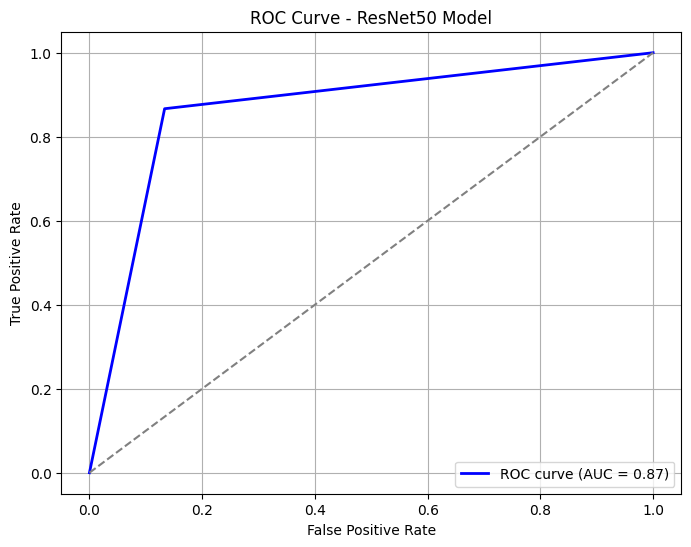

In [ ]:
model.load_state_dict(torch.load("/content/best_resnet50_T1_huhu.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader: #thay của val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_W2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_W2.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_W2.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/img_data/drawings/wave/testlol"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh V08PO01.png: Parkinson
Ảnh V04HO01.png: Healthy
Ảnh V02HO01.png: Healthy
Ảnh V03HO01.png: Healthy
Ảnh V07HO01.png: Healthy
Ảnh V55HO08.png: Healthy
Ảnh V01HO01.png: Healthy
Ảnh V55HO10.png: Healthy
Ảnh V07PO01.png: Parkinson
Ảnh V03PO01.png: Parkinson
Ảnh V05PO01.png: Parkinson
Ảnh V11HO01.png: Healthy
Ảnh V06PO01.png: Parkinson
Ảnh V55HO09.png: Healthy
Ảnh V14PO03.png: Parkinson
Ảnh V08HO01.png: Healthy
Ảnh V09PO01.png: Parkinson
Ảnh V10PO01.png: Parkinson
Ảnh V06HO01.png: Healthy
Ảnh V14PO01.png: Parkinson
Ảnh V09HO01.png: Healthy
Ảnh V10HO01.png: Parkinson
Ảnh V11PO01.png: Parkinson
Ảnh V03PO04.png: Parkinson
Ảnh V04PO01.png: Parkinson
Ảnh V03PO07.png: Parkinson
Ảnh V02PO01.png: Parkinson
Ảnh V55HO11.png: Parkinson
Ảnh V05HO01.png: Healthy
Ảnh V01PO01.png: Parkinson


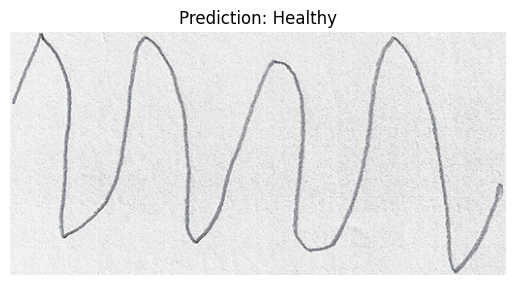

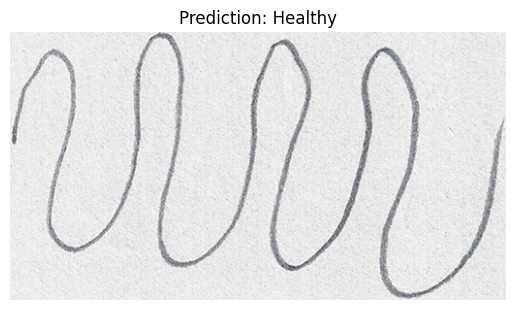

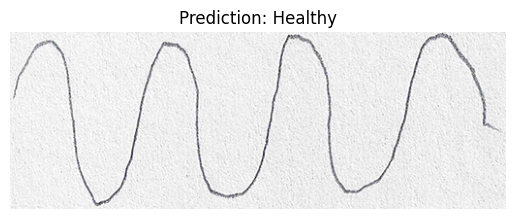

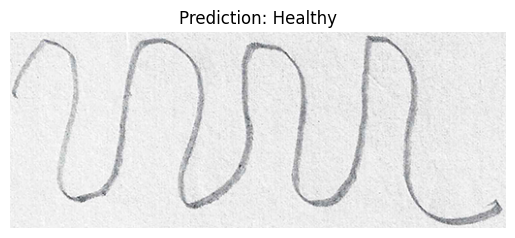

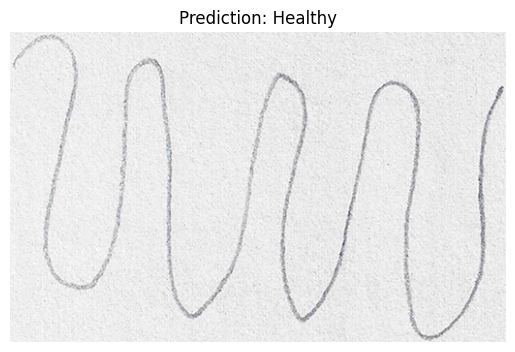

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

# **VGG19**

> **SPIRAL IMAGES**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from sklearn.model_selection import KFold
import copy
import matplotlib.pyplot as plt

Using device: cuda

=== Training with Learning Rate: 0.001 ===
Fold 1/5
Epoch 1/20: Train Loss: 3.1510, Train Acc: 0.4561, Val Loss: 0.8229, Val Acc: 0.6667
Epoch 2/20: Train Loss: 0.9788, Train Acc: 0.4561, Val Loss: 0.6744, Val Acc: 0.6667
Epoch 3/20: Train Loss: 0.6954, Train Acc: 0.5088, Val Loss: 0.6857, Val Acc: 0.6667
Epoch 4/20: Train Loss: 1.1900, Train Acc: 0.4386, Val Loss: 0.7212, Val Acc: 0.3333
Epoch 5/20: Train Loss: 0.6805, Train Acc: 0.5439, Val Loss: 0.9431, Val Acc: 0.3333
Epoch 6/20: Train Loss: 0.7676, Train Acc: 0.5439, Val Loss: 0.8485, Val Acc: 0.3333
Epoch 7/20: Train Loss: 0.6932, Train Acc: 0.5439, Val Loss: 0.7730, Val Acc: 0.3333
Epoch 8/20: Train Loss: 0.6833, Train Acc: 0.5439, Val Loss: 0.7446, Val Acc: 0.3333
Epoch 9/20: Train Loss: 0.6900, Train Acc: 0.5439, Val Loss: 0.7439, Val Acc: 0.3333
Epoch 10/20: Train Loss: 0.6869, Train Acc: 0.5439, Val Loss: 0.7425, Val Acc: 0.3333
Epoch 11/20: Train Loss: 0.6884, Train Acc: 0.5439, Val Loss: 0.7400, Val Acc

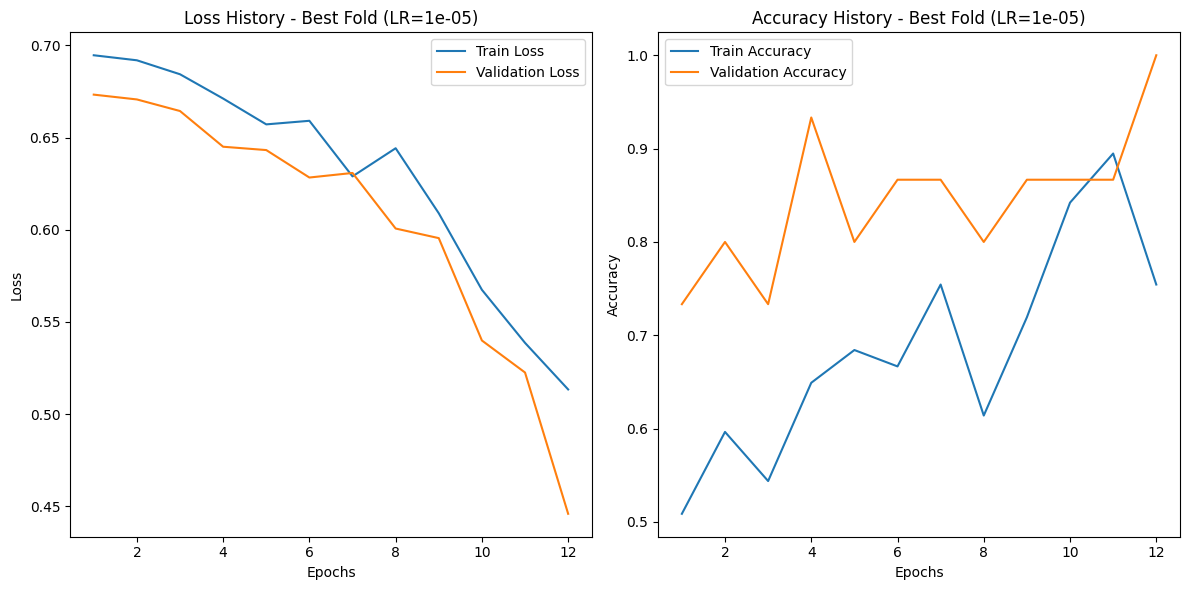


=== Testing on Test Set ===
Test Accuracy: 0.7333


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
from sklearn.model_selection import KFold
import copy
import matplotlib.pyplot as plt

# Thêm rotation và flip để mô hình học được nhiều góc độ của ảnh
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng VGG19
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Sửa normalization cho ImageNet
])

dataset_path_spiral = "/content/drive/MyDrive/Colab Notebooks/img_data/spiral"
dataset1 = datasets.ImageFolder(root=f"{dataset_path_spiral}/training", transform=transform)
num_classes = len(dataset1.classes)

test_dataset = datasets.ImageFolder(root=f"{dataset_path_spiral}/testing", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # Thêm random_state
learning_rates = [1e-3, 1e-4, 1e-5]  # tuning learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Biến để lưu best của learning rate tốt nhất
best_lr = None
best_lr_avg_acc = 0.0
best_lr_model_state = None
best_lr_train_loss_history = None
best_lr_val_loss_history = None
best_lr_train_acc_history = None
best_lr_val_acc_history = None
best_lr_fold_results = None

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    fold_results = []

    # Biến để lưu best fold của learning rate hiện tại
    best_fold_for_lr_acc = 0.0
    best_fold_for_lr_model = None
    best_fold_for_lr_train_loss = None
    best_fold_for_lr_val_loss = None
    best_fold_for_lr_train_acc = None
    best_fold_for_lr_val_acc = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset1)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler = torch.utils.data.Subset(dataset1, train_idx)
        val_subsampler = torch.utils.data.Subset(dataset1, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=32, shuffle=False)

        # Sử dụng phiên bản mới của torchvision
        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)  # dùng pretrained ImageNet
        # Sửa lại classifier (fully connected layers)
        model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Bỏ verbose

        best_fold_acc = 0.0
        best_fold_model = None

        # Thêm biến để lưu history của best fold
        best_fold_train_loss_history = None
        best_fold_val_loss_history = None
        best_fold_train_acc_history = None
        best_fold_val_acc_history = None

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        for epoch in range(20):  # Giảm epoch để test nhanh
            model.train()
            running_loss, correct_train = 0.0, 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)
                total_train += labels.size(0)

            train_loss = running_loss / total_train
            train_acc = correct_train / total_train

            # Validation
            model.eval()
            running_val_loss, correct_val = 0.0, 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)
                    total_val += labels.size(0)

            val_loss = running_val_loss / total_val if total_val > 0 else 0
            val_acc = correct_val / total_val if total_val > 0 else 0

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/20: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = copy.deepcopy(model.state_dict())
                # Lưu history của best epoch trong fold
                best_fold_train_loss_history = train_loss_history.copy()
                best_fold_val_loss_history = val_loss_history.copy()
                best_fold_train_acc_history = train_acc_history.copy()
                best_fold_val_acc_history = val_acc_history.copy()

        fold_results.append(best_fold_acc)
        print(f"Best fold accuracy: {best_fold_acc:.4f}")

        # Cập nhật best fold cho learning rate hiện tại
        if best_fold_acc > best_fold_for_lr_acc:
            best_fold_for_lr_acc = best_fold_acc
            best_fold_for_lr_model = best_fold_model
            best_fold_for_lr_train_loss = best_fold_train_loss_history
            best_fold_for_lr_val_loss = best_fold_val_loss_history
            best_fold_for_lr_train_acc = best_fold_train_acc_history
            best_fold_for_lr_val_acc = best_fold_val_acc_history

    avg_acc = np.mean(fold_results)
    print(f"Learning Rate {lr} - Fold Accuracies: {fold_results}")
    print(f"Average Accuracy for LR={lr}: {avg_acc:.4f} ± {np.std(fold_results):.4f}")

    # Cập nhật best learning rate
    if avg_acc > best_lr_avg_acc:
        best_lr_avg_acc = avg_acc
        best_lr = lr
        best_lr_model_state = best_fold_for_lr_model
        best_lr_train_loss_history = best_fold_for_lr_train_loss
        best_lr_val_loss_history = best_fold_for_lr_val_loss
        best_lr_train_acc_history = best_fold_for_lr_train_acc
        best_lr_val_acc_history = best_fold_for_lr_val_acc
        best_lr_fold_results = fold_results.copy()

    print(f"Current best LR: {best_lr} with avg accuracy: {best_lr_avg_acc:.4f}\n")

# Lưu model
if best_lr_model_state is not None:
    torch.save(best_lr_model_state, "best_VGG19_T1.pth")
    print(f"=== MODEL SAVING INFORMATION ===")
    print(f"Best learning rate: {best_lr}")
    print(f"Average accuracy for this LR: {best_lr_avg_acc:.4f}")
    print(f"Fold accuracies: {best_lr_fold_results}")
    print(f"Best fold accuracy: {max(best_lr_fold_results):.4f}")
    print(f"Model saved from best fold of best learning rate")
    print(f"File: best_VGG19_T1.pth")
    print("=" * 40)

    # Vẽ biểu đồ history của best fold từ learning rate tốt nhất
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_lr_train_loss_history) + 1), best_lr_train_loss_history, label="Train Loss")
    plt.plot(range(1, len(best_lr_val_loss_history) + 1), best_lr_val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss History - Best Fold (LR={best_lr})")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_lr_train_acc_history) + 1), best_lr_train_acc_history, label="Train Accuracy")
    plt.plot(range(1, len(best_lr_val_acc_history) + 1), best_lr_val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy History - Best Fold (LR={best_lr})")
    plt.tight_layout()
    plt.show()

    # Test trên test set
    print("\n=== Testing on Test Set ===")
    test_model = models.vgg19(weights=None)
    test_model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    test_model.load_state_dict(best_lr_model_state)
    test_model = test_model.to(device)
    test_model.eval()

    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = test_model(inputs)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    print("No model to save!")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg19 = models.vgg19(weights=None)  # Không dùng pretrained vì ta load trọng số riêng
model_vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)

# Load trọng số đã train
model_vgg19.load_state_dict(torch.load("/content/best_VGG19_T1.pth", map_location=device))

model_vgg19.to(device)
model_vgg19.eval()

print("model loaded successfully!")


model loaded successfully!


In [ ]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader của bạn
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_vgg19(inputs)   # 🔹 Dùng model_vgg19 thay cho model_resnet
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset1.classes))



Classification Report:
              precision    recall  f1-score   support

     healthy       0.71      0.80      0.75        15
   parkinson       0.77      0.67      0.71        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

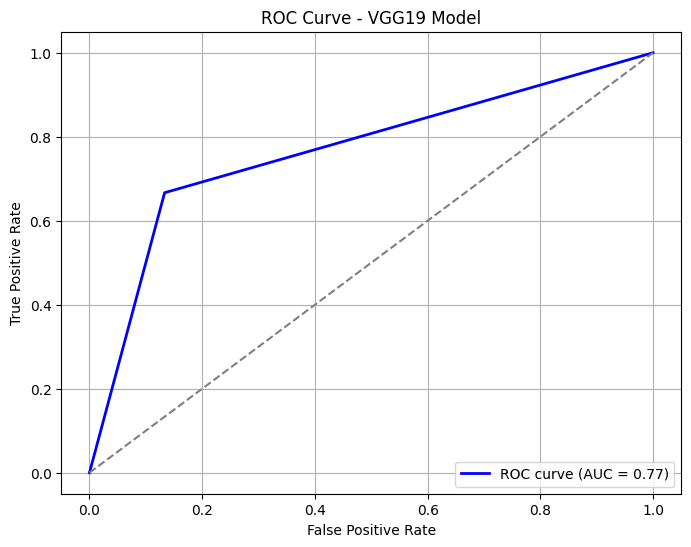

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model.load_state_dict(torch.load("/content/best_VGG19_T1.pth", map_location=device))
model = model.to(device)   # <-- thêm dòng này
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader thay cho val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VGG19 Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_SR3.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_SR3.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg19(weights=None)  # Không dùng pretrained vì ta load trọng số riêng
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_SR3.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/img_data/drawings/spiral/testing/testfvck"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh V14PE03.png: Parkinson
Ảnh V08HE01.png: Healthy
Ảnh V10PE03.png: Healthy
Ảnh V55HE15.png: Healthy
Ảnh V10HE01.png: Healthy
Ảnh V08PE01.png: Healthy
Ảnh V07PE01.png: Parkinson
Ảnh V04PE01.png: Parkinson
Ảnh V05HE01.png: Healthy
Ảnh V07HE01.png: Healthy
Ảnh V01HE01.png: Healthy
Ảnh V01PE01.png: Healthy
Ảnh V06PE01.png: Parkinson
Ảnh V55HE13.png: Healthy
Ảnh V11HE01.png: Healthy
Ảnh V09PE01.png: Parkinson
Ảnh V55HE12.png: Healthy
Ảnh V11PE03.png: Parkinson
Ảnh V03HE1.png: Healthy
Ảnh V06HE01.png: Parkinson
Ảnh V03PE01.png: Parkinson
Ảnh V03PE04.png: Parkinson
Ảnh V04HE01.png: Healthy
Ảnh V15PE01.png: Healthy
Ảnh V05PE01.png: Parkinson
Ảnh V03PE07.png: Parkinson
Ảnh V02HE01.png: Parkinson
Ảnh V09HE01.png: Healthy
Ảnh V02PE01.png: Parkinson
Ảnh V55HE14.png: Healthy


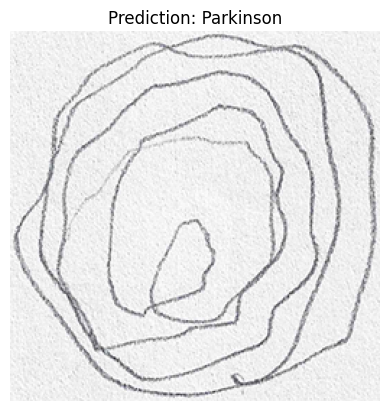

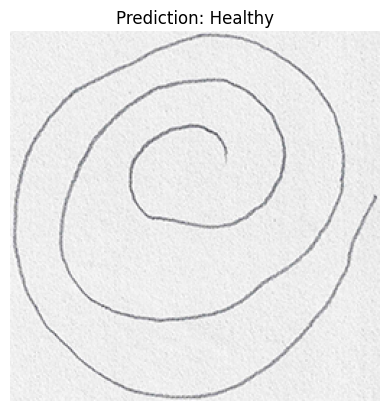

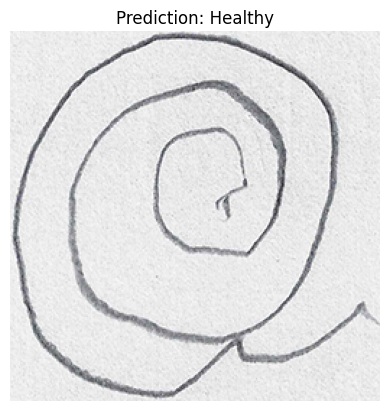

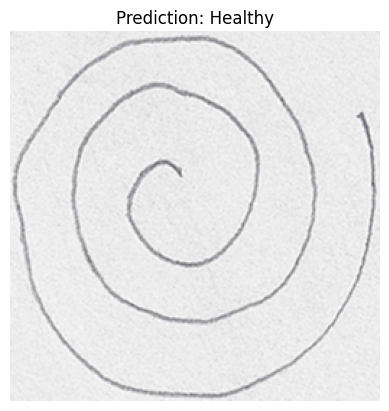

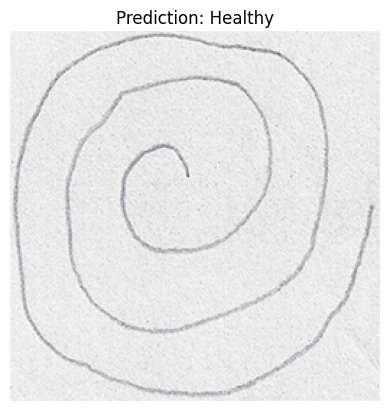

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

> **WAVE IMAGES**

Using device: cuda

=== Training with Learning Rate: 0.001 ===
Fold 1/5
Epoch 1/20: Train Loss: 2.2281, Train Acc: 0.5088, Val Loss: 8.7977, Val Acc: 0.6667
Epoch 2/20: Train Loss: 8.2941, Train Acc: 0.4561, Val Loss: 0.6923, Val Acc: 0.6667
Epoch 3/20: Train Loss: 0.6941, Train Acc: 0.4386, Val Loss: 0.6434, Val Acc: 0.6667
Epoch 4/20: Train Loss: 0.7388, Train Acc: 0.5088, Val Loss: 0.7773, Val Acc: 0.3333
Epoch 5/20: Train Loss: 1.8964, Train Acc: 0.5263, Val Loss: 0.7741, Val Acc: 0.3333
Epoch 6/20: Train Loss: 0.6919, Train Acc: 0.5439, Val Loss: 0.7359, Val Acc: 0.3333
Epoch 7/20: Train Loss: 0.6933, Train Acc: 0.5439, Val Loss: 0.7350, Val Acc: 0.3333
Epoch 8/20: Train Loss: 0.6859, Train Acc: 0.5439, Val Loss: 0.7307, Val Acc: 0.3333
Epoch 9/20: Train Loss: 0.6925, Train Acc: 0.5439, Val Loss: 0.7290, Val Acc: 0.3333
Epoch 10/20: Train Loss: 0.6955, Train Acc: 0.5439, Val Loss: 0.7263, Val Acc: 0.3333
Epoch 11/20: Train Loss: 0.6856, Train Acc: 0.5439, Val Loss: 0.7286, Val Acc

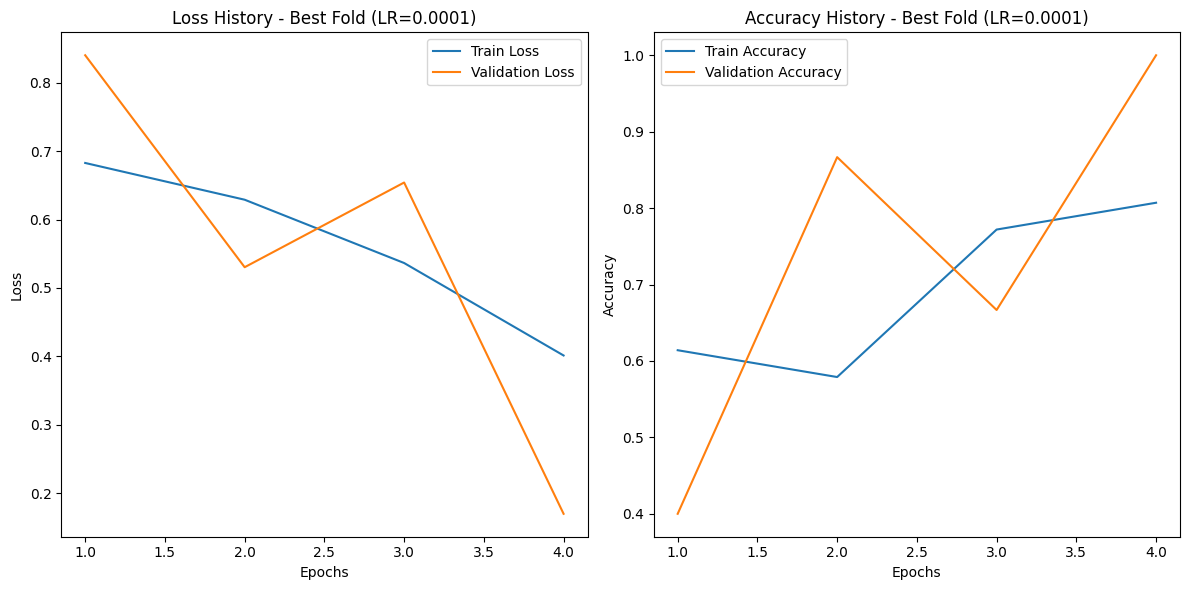


=== Testing on Test Set ===
Test Accuracy: 0.6333


In [ ]:
# Thêm rotation và flip để mô hình học được nhiều góc độ của ảnh
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng resnet50
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Sửa normalization cho ImageNet
])

dataset_wave = "/content/drive/MyDrive/Colab Notebooks/img_data/wave"
dataset1 = datasets.ImageFolder(root=f"{dataset_wave}/training", transform=transform)
num_classes = len(dataset1.classes)

test_dataset = datasets.ImageFolder(root=f"{dataset_wave}/testing", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # Thêm random_state
learning_rates = [1e-3, 1e-4, 1e-5]  # tuning learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Biến để lưu best của learning rate tốt nhất
best_lr = None
best_lr_avg_acc = 0.0
best_lr_model_state = None
best_lr_train_loss_history = None
best_lr_val_loss_history = None
best_lr_train_acc_history = None
best_lr_val_acc_history = None
best_lr_fold_results = None

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    fold_results = []

    # Biến để lưu best fold của learning rate hiện tại
    best_fold_for_lr_acc = 0.0
    best_fold_for_lr_model = None
    best_fold_for_lr_train_loss = None
    best_fold_for_lr_val_loss = None
    best_fold_for_lr_train_acc = None
    best_fold_for_lr_val_acc = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset1)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler = torch.utils.data.Subset(dataset1, train_idx)
        val_subsampler = torch.utils.data.Subset(dataset1, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=32, shuffle=False)

        # Sử dụng phiên bản mới của torchvision
        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)  # dùng pretrained ImageNet
        # Sửa lại classifier (fully connected layers)
        model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Bỏ verbose

        best_fold_acc = 0.0
        best_fold_model = None

        # Thêm biến để lưu history của best fold
        best_fold_train_loss_history = None
        best_fold_val_loss_history = None
        best_fold_train_acc_history = None
        best_fold_val_acc_history = None

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        for epoch in range(20):  # Giảm epoch để test nhanh
            model.train()
            running_loss, correct_train = 0.0, 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)
                total_train += labels.size(0)

            train_loss = running_loss / total_train
            train_acc = correct_train / total_train

            # Validation
            model.eval()
            running_val_loss, correct_val = 0.0, 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)
                    total_val += labels.size(0)

            val_loss = running_val_loss / total_val if total_val > 0 else 0
            val_acc = correct_val / total_val if total_val > 0 else 0

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/20: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = copy.deepcopy(model.state_dict())
                # Lưu history của best epoch trong fold
                best_fold_train_loss_history = train_loss_history.copy()
                best_fold_val_loss_history = val_loss_history.copy()
                best_fold_train_acc_history = train_acc_history.copy()
                best_fold_val_acc_history = val_acc_history.copy()

        fold_results.append(best_fold_acc)
        print(f"Best fold accuracy: {best_fold_acc:.4f}")

        # Cập nhật best fold cho learning rate hiện tại
        if best_fold_acc > best_fold_for_lr_acc:
            best_fold_for_lr_acc = best_fold_acc
            best_fold_for_lr_model = best_fold_model
            best_fold_for_lr_train_loss = best_fold_train_loss_history
            best_fold_for_lr_val_loss = best_fold_val_loss_history
            best_fold_for_lr_train_acc = best_fold_train_acc_history
            best_fold_for_lr_val_acc = best_fold_val_acc_history

    avg_acc = np.mean(fold_results)
    print(f"Learning Rate {lr} - Fold Accuracies: {fold_results}")
    print(f"Average Accuracy for LR={lr}: {avg_acc:.4f} ± {np.std(fold_results):.4f}")

    # Cập nhật best learning rate
    if avg_acc > best_lr_avg_acc:
        best_lr_avg_acc = avg_acc
        best_lr = lr
        best_lr_model_state = best_fold_for_lr_model
        best_lr_train_loss_history = best_fold_for_lr_train_loss
        best_lr_val_loss_history = best_fold_for_lr_val_loss
        best_lr_train_acc_history = best_fold_for_lr_train_acc
        best_lr_val_acc_history = best_fold_for_lr_val_acc
        best_lr_fold_results = fold_results.copy()

    print(f"Current best LR: {best_lr} with avg accuracy: {best_lr_avg_acc:.4f}\n")

# Lưu model
if best_lr_model_state is not None:
    torch.save(best_lr_model_state, "best_VGG19_T1.pth")
    print(f"=== MODEL SAVING INFORMATION ===")
    print(f"Best learning rate: {best_lr}")
    print(f"Average accuracy for this LR: {best_lr_avg_acc:.4f}")
    print(f"Fold accuracies: {best_lr_fold_results}")
    print(f"Best fold accuracy: {max(best_lr_fold_results):.4f}")
    print(f"Model saved from best fold of best learning rate")
    print(f"File: best_VGG19_T1.pth")
    print("=" * 40)

    # Vẽ biểu đồ history của best fold từ learning rate tốt nhất
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_lr_train_loss_history) + 1), best_lr_train_loss_history, label="Train Loss")
    plt.plot(range(1, len(best_lr_val_loss_history) + 1), best_lr_val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss History - Best Fold (LR={best_lr})")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_lr_train_acc_history) + 1), best_lr_train_acc_history, label="Train Accuracy")
    plt.plot(range(1, len(best_lr_val_acc_history) + 1), best_lr_val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy History - Best Fold (LR={best_lr})")
    plt.tight_layout()
    plt.show()

    # Test trên test set
    print("\n=== Testing on Test Set ===")
    test_model = models.vgg19(weights=None)
    test_model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    test_model.load_state_dict(best_lr_model_state)
    test_model = test_model.to(device)
    test_model.eval()

    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = test_model(inputs)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    print("No model to save!")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg19 = models.vgg19(weights=None)  # Không dùng pretrained vì ta load trọng số riêng
model_vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)

# Load trọng số đã train
model_vgg19.load_state_dict(torch.load("/content/best_VGG19_T1.pth", map_location=device))

model_vgg19.to(device)
model_vgg19.eval()

print("model loaded successfully!")


model loaded successfully!


In [ ]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader của bạn
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_vgg19(inputs)   # 🔹 Dùng model_vgg19 thay cho model_resnet
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset1.classes))



Classification Report:
              precision    recall  f1-score   support

     healthy       0.89      0.53      0.67        15
   parkinson       0.67      0.93      0.78        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



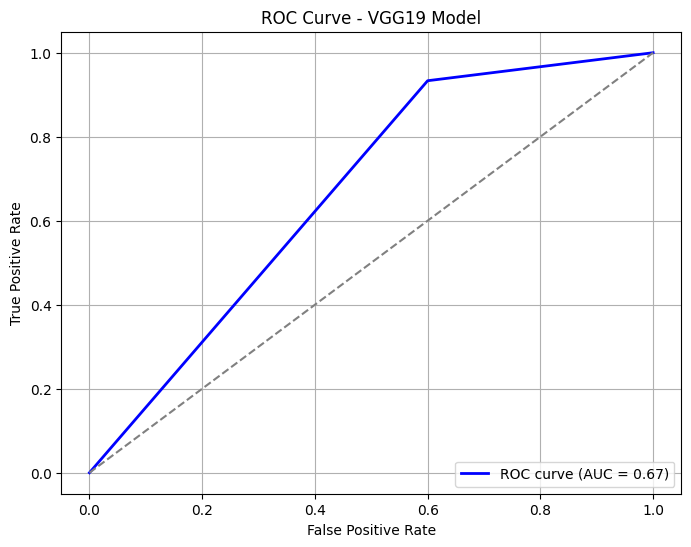

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model.load_state_dict(torch.load("/content/best_VGG19_T1.pth", map_location=device))
model = model.to(device)   # <-- thêm dòng này
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader thay cho val_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VGG19 Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_W2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_W2.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg19 = models.vgg19(weights=None)  # Không dùng pretrained vì ta load trọng số riêng
model_vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/save models/best_VGG19_W2.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/img_data/drawings/wave/testlol"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh V08PO01.png: Healthy
Ảnh V04HO01.png: Healthy
Ảnh V02HO01.png: Healthy
Ảnh V03HO01.png: Parkinson
Ảnh V07HO01.png: Parkinson
Ảnh V55HO08.png: Parkinson
Ảnh V01HO01.png: Healthy
Ảnh V55HO10.png: Healthy
Ảnh V07PO01.png: Parkinson
Ảnh V03PO01.png: Parkinson
Ảnh V05PO01.png: Parkinson
Ảnh V11HO01.png: Healthy
Ảnh V06PO01.png: Parkinson
Ảnh V55HO09.png: Parkinson
Ảnh V14PO03.png: Parkinson
Ảnh V08HO01.png: Healthy
Ảnh V09PO01.png: Parkinson
Ảnh V10PO01.png: Parkinson
Ảnh V06HO01.png: Parkinson
Ảnh V14PO01.png: Parkinson
Ảnh V09HO01.png: Healthy
Ảnh V10HO01.png: Healthy
Ảnh V11PO01.png: Parkinson
Ảnh V03PO04.png: Parkinson
Ảnh V04PO01.png: Parkinson
Ảnh V03PO07.png: Parkinson
Ảnh V02PO01.png: Parkinson
Ảnh V55HO11.png: Parkinson
Ảnh V05HO01.png: Parkinson
Ảnh V01PO01.png: Parkinson


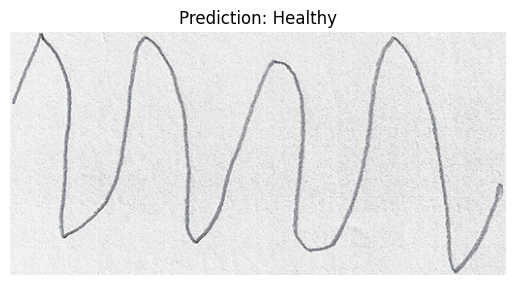

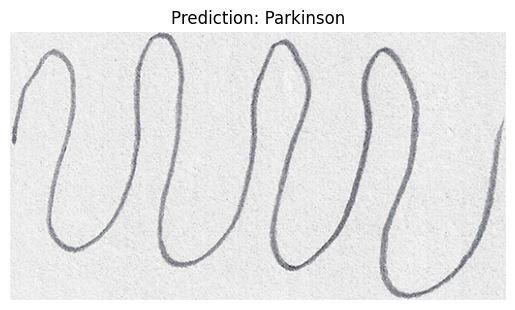

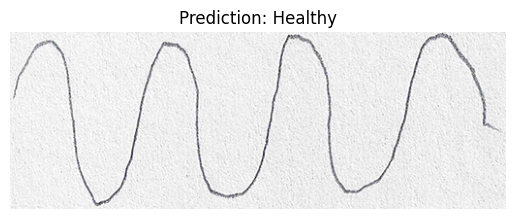

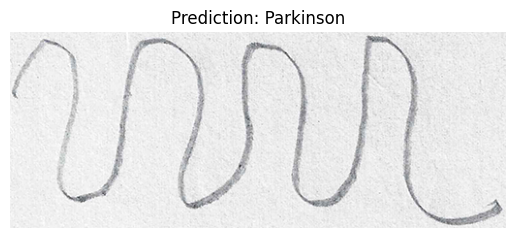

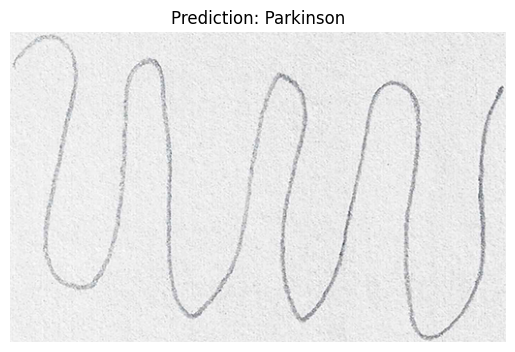

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Healthy" if predicted.item() == 0 else "Parkinson"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()